In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [6]:
path_to_data = '/Users/janbraunsdorff/Studienarbeit-projekt/data'
path_to_validation_annotation = path_to_data + "/validation.csv"
path_to_training_annotation = path_to_data + "/training.csv"
path_to_validatoin_data = path_to_data + '/boneage-validation-dataset/'
path_to_training_data = path_to_data + '/boneage-training-dataset/'
path = path_to_data + '/pickel/v3'

In [7]:
def p1(img, resize_to=500):
    img = cv2.resize(img, (resize_to, resize_to), interpolation=cv2.INTER_LINEAR)
    return img

In [5]:
def p2(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr

In [6]:
def p3(img, resize_to=500, reduce_to=380):
    x = y = (resize_to - reduce_to) // 2
    h = w = reduce_to
    img = img[y:y + h, x:x + w]
    return img

In [7]:
def p4(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return img

In [8]:
def p5(img):
    kernel = np.ones((2,2),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

In [9]:
def p6(img, out_to=256):
    img = cv2.resize(img, (out_to, out_to), interpolation=cv2.INTER_LINEAR)
    return img

In [10]:
def process_img(img, resize_to = 500, reduce_to = 380, out_to = 256):
    img = p1(img, resize_to=reduce_to)
    img = p2(img)
    img = p3(img, resize_to=resize_to, reduce_to=reduce_to)
    img = p4(img)
    img = p5(img)
    img = p6(img, out_to=out_to)
    return img

In [11]:
def print_prcessed(path):
    plt.rcParams["figure.figsize"] = (16, 5)
    plt.rcParams["figure.dpi"] = 256
    img = cv2.imread(path)
    num = 7
    resize_to = 500
    reduce_to = 380
    out_to = 299


    f = plt.figure()

    f.add_subplot(1, num, 1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Original')

    img = p1(img, resize_to=reduce_to)
    f.add_subplot(1, num, 2)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Resize')

    img = p2(img)
    f.add_subplot(1, num, 3)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CLAHE')


    img = p3(img, resize_to=resize_to, reduce_to=reduce_to)
    f.add_subplot(1, num, 4)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CROP')

    img = p4(img)
    f.add_subplot(1, num, 5)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CLHAE')

    img = p5(img)
    f.add_subplot(1, num, 6)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Open')

    img = p6(img, out_to=out_to)
    f.add_subplot(1, num, 7)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CROP')


    plt.imshow(img, cmap='gray')

In [12]:
def get_img(aug):
    img = cv2.imread(path_to_training_data + "1377.png")
    img = process_img(img, out_to = 299)
    img = torch.tensor(img).float()
    img = img.permute(2,0,1)
    img = aug(img)
    img = img.permute(1,2,0) / 255.0
    return img

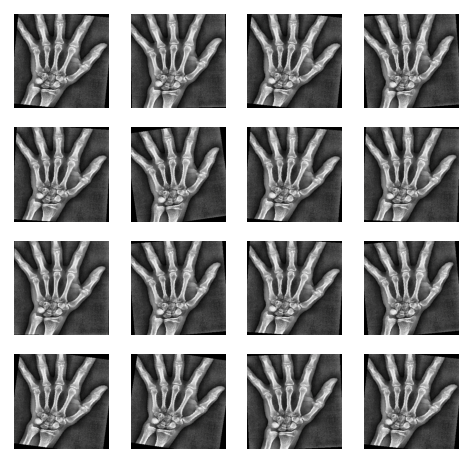

In [13]:
n = 16
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 144
f = plt.figure()
f.tight_layout()

aug = transforms.Compose(
        [
            transforms.RandomRotation(degrees=10),
        ]
    )


for i in range(n):
    f.add_subplot(4, 4, i+1)
    img = get_img(aug)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

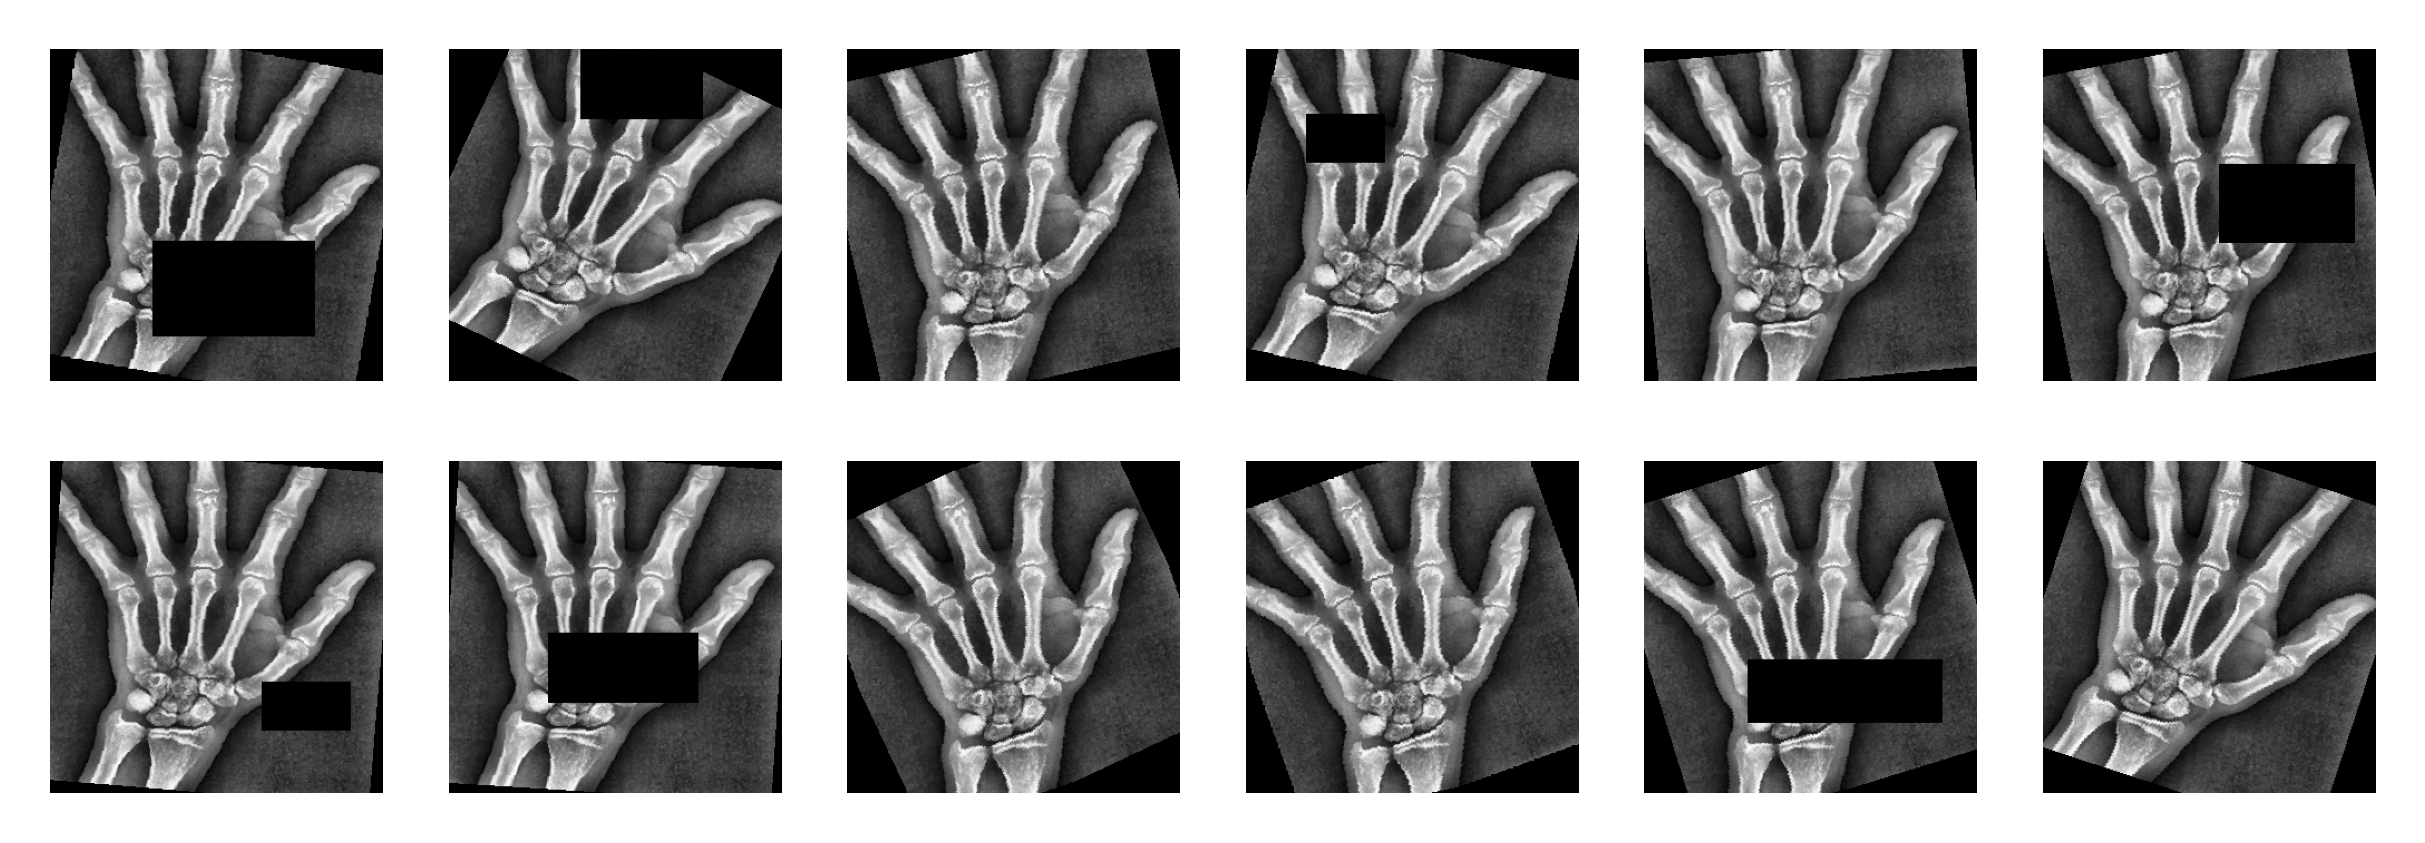

In [16]:
n = 12
plt.rcParams["figure.figsize"] = (6, 2)
plt.rcParams["figure.dpi"] = 500
f = plt.figure()
f.tight_layout()

aug = transforms.Compose(
        [
            transforms.RandomRotation(degrees=10),
            transforms.RandomApply([
                transforms.RandomAffine(degrees=30)
            ], p=0.7),
            transforms.RandomErasing(p=0.4, scale=(0.02, 0.2), ratio=(0.1, 0.7))

        ]
    )


for i in range(n):
    f.add_subplot(2, 6, i+1)
    img = get_img(aug)
    plt.imshow(img)
    plt.axis('off')

In [14]:
img = cv2.imread(path_to_training_data + "1377.png")
img = process_img(img)

In [15]:
class Patches(nn.Module):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def forward(self, images):
    # 256, 3, 72, 72
    batch = images.size()[0]
    patches = images.unfold(1, 3, 3).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
    patches = patches.squeeze(1)
    patches = patches.resize(batch, 16*16 ,3 * self.patch_size* self.patch_size)
    return patches

/usr/local/lib/python3.9/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 576x576 with 0 Axes>

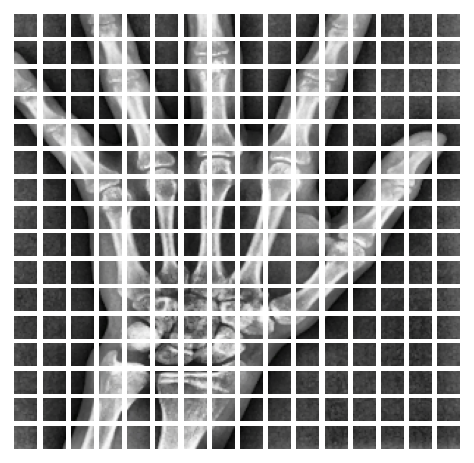

In [16]:
plt.figure(figsize=(4,4))
n = 16
plt.figure(figsize=(4,4))
patches = Patches(patch_size=16)(torch.tensor(img).permute(2,0,1).unsqueeze(0))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = patch.reshape(3, 16, 16).permute(1,2,0)
    plt.imshow(patch_img.numpy())
    plt.axis('off')


(-0.5, 255.5, 255.5, -0.5)

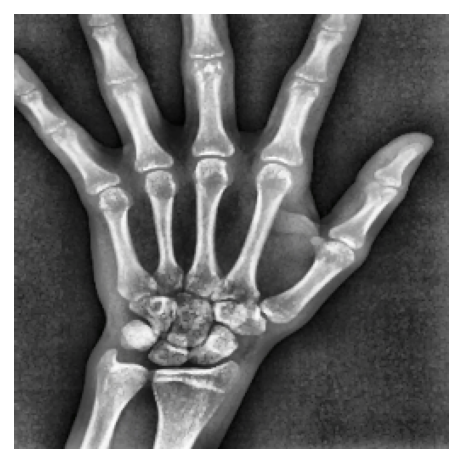

In [17]:
plt.imshow(img)
plt.axis('off')

In [11]:
content = []
with open('/Users/janbraunsdorff/studienarbeit/log-vit.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [28]:
def print_plot(acc, loss, c):
    plt.rcParams["figure.figsize"] = (16, 5)
    plt.rcParams["figure.dpi"] = 256
    f = plt.figure()

    ax = f.add_subplot(1, 3, 1)
    for i in acc:
         plt.plot(i)
    plt.xlabel('Epochen')
    plt.ylabel('Genauigkeit')
    plt.title('Durchnittlicher Fehler in Monaten')
    ax.set_ylim(0, 50)
    plt.legend(['Trainig', 'Validation'])

    ax = f.add_subplot(1, 3, 2)
    for i in loss:
         plt.plot(i)
    plt.xlabel('Epochen')
    plt.ylabel('Fehler')
    plt.title('Durchschnittlicher Fehler der Fehlerfunktion')
    ax.set_ylim(0, 3500)
    plt.legend(['Trainig', 'Validation'])


    ax = f.add_subplot(1, 3, 3)
    for i in c:
        plt.plot(i)
    plt.xlabel('Epochen')
    plt.ylabel('Score (c4*2.0 + c12 + c25*0.5) / Anzahl')
    plt.title('Fehlerklassen')
    plt.legend(['Trainig', 'Validation'])
    ax.set_ylim(0, 200)

    plt.show()

In [26]:
# Epoche: 1 [Done] 00:39 loss: 3487.1731, acc: 45.2324, c1: 6.49% c12: 17.91% c24: 34.85% score: 0.4830 | [Test] loss: 1734.8069, acc: 33.6578, c1: 1e+01% c12: 22.32% c24: 41.12% score: 0.6337 

datapoints = []
for l in content:
    val = l.split(' ')
    train_loss = float(val[5][:-1])
    train_acc = float(val[7][:-1].strip())
    train_c1 = float(val[9][:-1])
    train_c12 = float(val[11][:-1])
    train_c24 = float(val[13][:-1])
    train_score = float(val[15])

    val_loss = float(val[19][:-1])
    val_acc = float(val[21][:-1].strip())
    val_c1 = float(val[23][:-1])
    val_c12 = float(val[25][:-1])
    val_c24 = float(val[27][:-1])
    val_score = float(val[29])    

    datapoints.append((train_loss, train_acc, train_c1, train_c12, train_c24, train_score, val_loss, val_acc, val_c1, val_c12, val_c24, val_score))

datapoints = np.array(datapoints).astype(float)


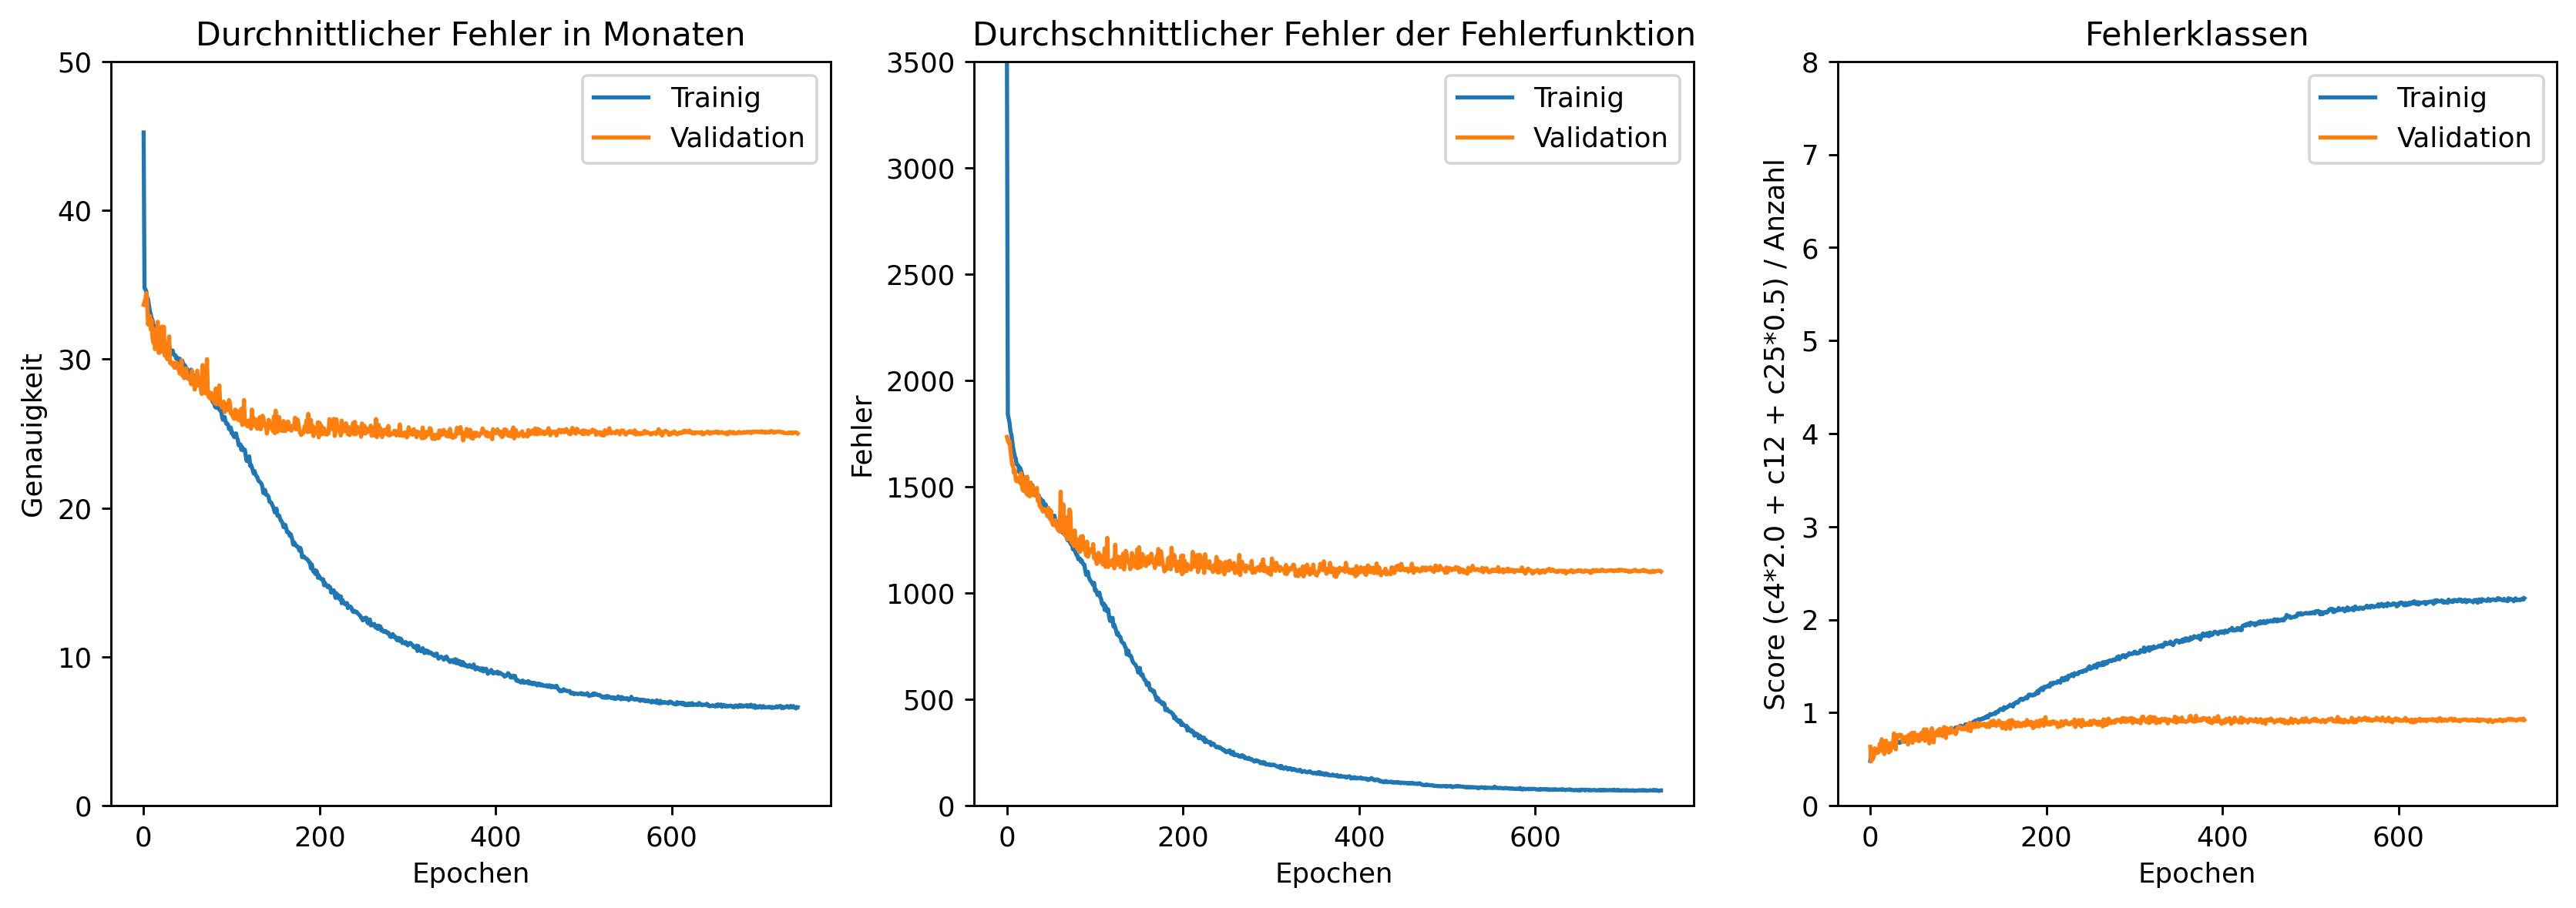

In [27]:

train_losses = [x[0] for x in datapoints]
valid_losses = [x[6] for x in datapoints]

train_acc = [x[1] for x in datapoints]
valid_acc = [x[7] for x in datapoints]

train_score = [x[5] for x in datapoints]
val_score = [x[11] for x in datapoints]


print_plot(
    acc = [train_acc, valid_acc],
    loss = [train_losses, valid_losses],
    c = [train_score, val_score]
)

In [30]:
import pandas as pd

In [31]:
pd = pd.read_csv('/Users/janbraunsdorff/studienarbeit/result-first.csv', sep=';', header=None)

In [32]:
pd

0      1            2          3          4          5          6   \
0      1  00:25  3545.390223  45.627346   6.232654  17.682975  34.684006   
1      2  00:25  1847.403165  34.976605   7.358655  20.616922  39.766870   
2      3  00:25  1821.190291  34.730713   7.469669  20.696218  40.131631   
3      4  00:25  1777.422727  34.350225   7.525176  20.616922  40.631195   
4      5  00:24  1730.127480  33.824608   7.588613  21.195781  41.368646   
..   ...    ...          ...        ...        ...        ...        ...   
252  253  00:23   528.980004  18.052485  16.327016  42.803901  72.936325   
253  254  00:23   523.169286  18.064763  16.081199  42.716676  72.008564   
254  255  00:25   517.633535  17.879609  16.422171  43.335184  72.952185   
255  256  00:24   528.507480  18.047135  16.382523  43.081437  72.587424   
256  257  00:27   512.892168  17.854022  16.406312  43.097296  73.007692   

             7            8          9          10         11         12  \
0     47.490286  1748.765447  33.394689   8.912281  24.000000  40.561404   
1     55.217667  1721.307893  34.120171   5.684211  19.859649  37.964912   
2     55.701372  1713.702874  32.936458   9.824561  23.157895  43.578947   
3     55.982872  1653.672125  33.101309   7.368421  21.614035  40.842105   
4     57.057331  1636.745044  33.261505   7.368421  20.421053  40.491228   
..          ...          ...        ...        ...        ...        ...   
252  111.926096  1107.591144  25.134979  12.912281  34.385965  59.719298   
253  110.883356  1117.988201  25.239618  12.561404  34.526316  59.929825   
254  112.655618  1110.028075  25.118711  12.631579  35.298246  59.859649   
255  112.140195  1117.240298  25.175247  13.543860  34.596491  59.228070   
256  112.413766  1116.697068  25.139615  13.614035  34.315789  59.649123   

            13  
0    62.105263  
1    50.210526  
2    64.596491  
3    56.771930  
4    55.403509  
..         ...  
252  90.070175  
253  89.614035  
254  90.491228  
255  91.298246  
256  91.368421  

[257 rows x 14 columns]

In [33]:
train_losses =  np.array(pd[2])
valid_losses =  np.array(pd[8])

train_acc =  np.array(pd[3])
valid_acc =  np.array(pd[9])

train_score =  np.array(pd[7])
val_score =  np.array(pd[13])

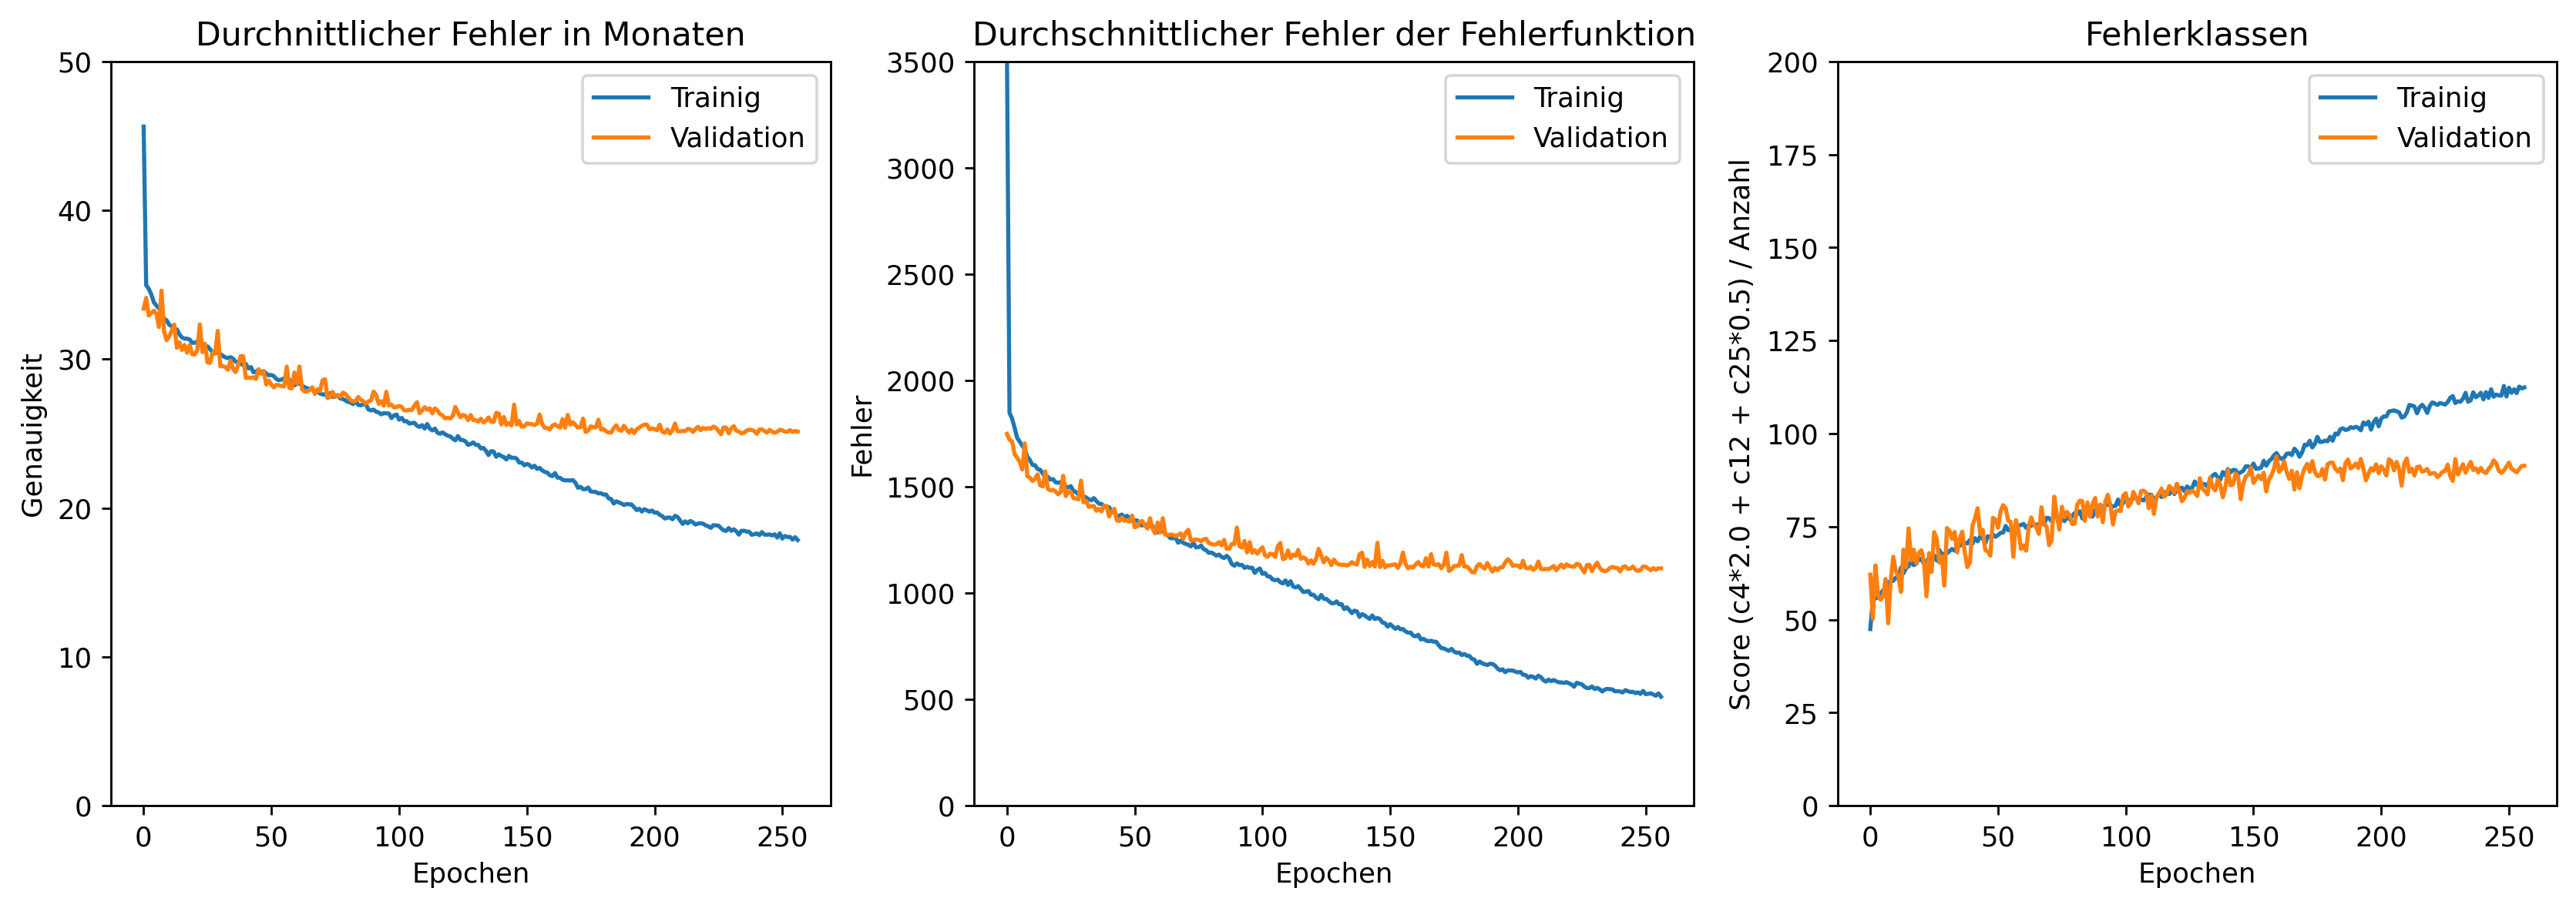

In [34]:
print_plot(
    acc = [train_acc, valid_acc],
    loss = [train_losses, valid_losses],
    c = [train_score, val_score]
)